# Building Collaborative Filtering Recommendation Engines

In this post we will learn how to implement user-based recommender systems and item-based recommender systems.

We gonna use the MovieLens 100k dataset for this tutorial.

## Data Source

The MovieLens 100k dataset can be downloaded from the following link:
[http://files.grouplens.org/datasets/movielens/ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_distances

### Load data

In [2]:
path = "ml-100k/u.data"
df = pd.read_csv(path, sep='\t', names=["UserID", "ItemID", "Rating", "Timstamp"])

In [3]:
df.head()

,UserID,ItemID,Rating,Timstamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
df.shape

(100000, 4)

### Data exploration

(array([  6110.,      0.,  11370.,      0.,      0.,  27145.,      0.,
         34174.,      0.,  21201.]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <a list of 10 Patch objects>)

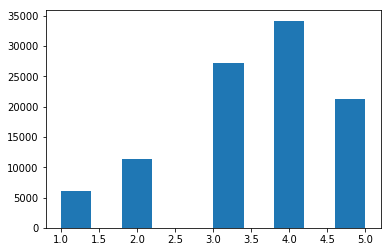

In [5]:
plt.hist(df['Rating'])

In [16]:
df.groupby(['Rating'])['UserID'].count()

Rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: UserID, dtype: int64

(array([  1.14600000e+03,   2.49000000e+02,   1.39000000e+02,
          6.70000000e+01,   3.80000000e+01,   2.40000000e+01,
          7.00000000e+00,   5.00000000e+00,   6.00000000e+00,
          1.00000000e+00]),
 array([   1. ,   59.2,  117.4,  175.6,  233.8,  292. ,  350.2,  408.4,
         466.6,  524.8,  583. ]),
 <a list of 10 Patch objects>)

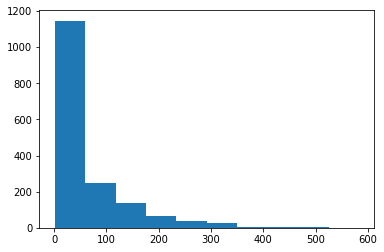

In [18]:
plt.hist(df.groupby(['ItemID'])['ItemID'].count())

### Rating matrix representation

In [6]:
users = list(np.sort(df.UserID.unique()))
items = list(df.ItemID.unique())
ratings = list(df.Rating)

rows = df.UserID.astype('category', categories=users).cat.codes
cols = df.ItemID.astype('category', categories=items).cat.codes

rating_matrix = sparse.csr_matrix((ratings, (rows, cols)), shape=(len(users), len(items)))

In [7]:
type(rating_matrix)

scipy.sparse.csr.csr_matrix

In [8]:
rating_matrix.shape

(943, 1682)

In [9]:
matrix_size = rating_matrix.shape[0]*rating_matrix.shape[1]
n_ratings = len(rating_matrix.nonzero()[0])
sparsity = 100 * (n_ratings/matrix_size)
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 6.30%


### Creating training and test sets

In [10]:
ratings_train, ratings_test = train_test_split(rating_matrix, test_size=0.33, random_state=42)

In [11]:
ratings_train.shape

(631, 1682)

In [12]:
type(ratings_train)

scipy.sparse.csr.csr_matrix

In [13]:
ratings_test.shape

(312, 1682)

### User-based similarity calculation

In [14]:
dist_out = 1 - cosine_distances(ratings_train)

In [15]:
dist_out = sparse.csr_matrix(dist_out)

In [16]:
type(dist_out)

scipy.sparse.csr.csr_matrix

In [17]:
dist_out.shape

(631, 631)

### Predicting the unknown ratings for an active user

In [18]:
ratings_sum = np.array([np.abs(dist_out).sum(axis=1)]).T

In [19]:
dot_matrix = dist_out.dot(ratings_train)

In [20]:
dot_matrix.shape

(631, 1682)

In [21]:
pred = dot_matrix / ratings_sum[0]

In [22]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [23]:
get_mse(pred, ratings_train)

7.8821939915510031

In [24]:
get_mse(pred, ratings_test)

8.9224954316965484